In [3]:
# download dataset
import urllib.request
import zipfile

urllib.request.urlretrieve("https://s3-us-west-2.amazonaws.com/cnnfun/heightweight.zip", "heightweight.zip")
zip_ref = zipfile.ZipFile(".", 'r')
zip_ref.extractall(".")
zip_ref.close()

('heightweight.zip', <http.client.HTTPMessage at 0x23e33a23860>)

In [9]:
import re
import glob
import numpy as np

# load dataset
dataset = []
for f in glob.glob('heightweight/*.jpg'):
    # NOTE: windows filesystem weirdness...
    f = f.replace("\\",'/')
    m = re.match('heightweight\/(\d+)-(\d+)_.*', f)
    if m:
        h = int(m.group(1))
        height = float(int(h / 100) * 12 + (h % 100)) * 2.54
        weight = float(m.group(2))
        dataset.append((f, height, weight))

total_sz = len(dataset)
val_sz = int(total_sz * 0.15)
test_sz = val_sz
train_sz = total_sz - val_sz - test_sz

ndata = np.array(dataset)
np.random.shuffle(ndata)

train = ndata[:train_sz]
val = ndata[train_sz:train_sz+val_sz]
test = ndata[train_sz+val_sz:]

print("train, val, test size: ", len(train), len(val), len(test))

train, val, test size:  822 176 176


In [10]:
# height
# train_files, train_targets = train[:,0], (np.array(train[:,1], dtype=float) - 120) / 100
# valid_files, valid_targets = val[:,0], (np.array(val[:,1], dtype=float) - 120) / 100
# test_files, test_targets = test[:,0], (np.array(test[:,1], dtype=float) - 120) / 100

# weight
train_files, train_targets = train[:,0], (np.array(train[:,2], dtype=float) - 50) / 300
valid_files, valid_targets = val[:,0], (np.array(val[:,2], dtype=float) - 50) / 300
test_files, test_targets = test[:,0], (np.array(test[:,2], dtype=float) - 50) / 300

In [11]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(400, 400))
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

Using TensorFlow backend.


In [12]:
# preprocess data
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 188.95it/s]


In [24]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='valid', activation='relu', 
                        input_shape=(400, 400, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 398, 398, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 199, 199, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 197, 197, 32)      4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 46, 46, 128)       73856     
__________

In [25]:
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])

In [26]:
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='saved_models/heightweight.weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=10, batch_size=20, callbacks=[checkpointer], verbose=0)

Epoch 00000: val_loss improved from inf to 0.04431, saving model to saved_models/heightweight.weights.best.from_scratch.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 0.04431 to 0.04308, saving model to saved_models/heightweight.weights.best.from_scratch.hdf5
Epoch 00003: val_loss improved from 0.04308 to 0.04045, saving model to saved_models/heightweight.weights.best.from_scratch.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 0.04045 to 0.03986, saving model to saved_models/heightweight.weights.best.from_scratch.hdf5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve


In [27]:
model.load_weights('saved_models/heightweight.weights.best.from_scratch.hdf5')

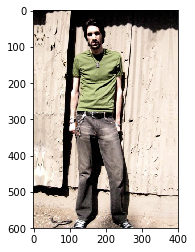

pred, true:  [[ 197.85348511]] 140.0


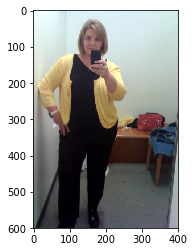

pred, true:  [[ 222.22648621]] 260.0


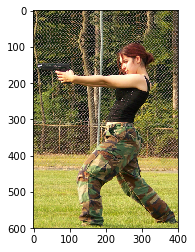

pred, true:  [[ 186.74510193]] 90.0


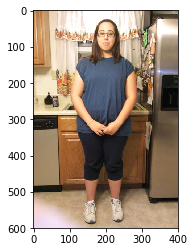

pred, true:  [[ 212.30914307]] 220.0


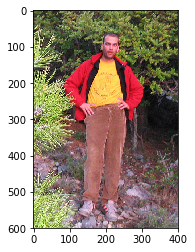

pred, true:  [[ 184.02952576]] 180.0


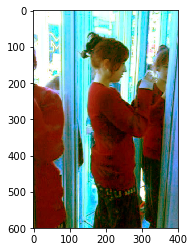

pred, true:  [[ 184.96539307]] 110.0


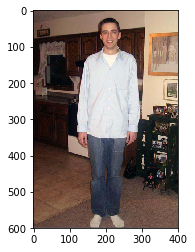

pred, true:  [[ 191.61347961]] 173.0


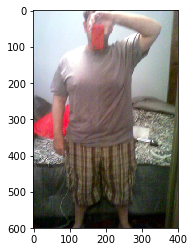

pred, true:  [[ 193.11422729]] 220.0


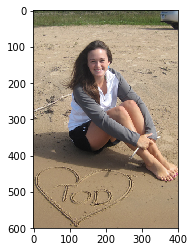

pred, true:  [[ 193.71342468]] 150.0


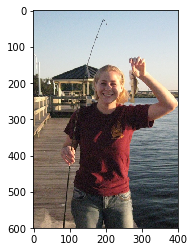

pred, true:  [[ 197.32839966]] 150.0


In [29]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# show test results
for i in range(10): #len(test_files)):
     # show the image
    img = cv2.imread(test_files[i])
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    predicted = model.predict(np.expand_dims(test_tensors[i], axis=0)) * 300.0 + 50.0
    actual = test_targets[i] * 300.0 + 50.0
    print("pred, true: ", predicted, actual)


In [191]:
height_predictions = [model.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors]